In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finetuned/config.json
/kaggle/input/finetuned/spiece.model
/kaggle/input/finetuned/training_args.bin
/kaggle/input/finetuned/tokenizer.json
/kaggle/input/finetuned/tokenizer_config.json
/kaggle/input/finetuned/pytorch_model.bin
/kaggle/input/finetuned/special_tokens_map.json
/kaggle/input/finetuned/generation_config.json
/kaggle/input/nlptweets/NLPData_chatGPT.csv


In [2]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.2 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.2 which is incompatible.
tensorboardx 2.5.1 requires protobuf<=3.20.1,>=3.8.0, but you have protobuf 3.20.2 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


### Free GPU Memory

In [7]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# import nltk
# from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

# nltk.download("punkt")

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading pre-trained model from hugging face

In [12]:
model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [25]:
model=model_pegasus

## Rogue Score Calculation

In [6]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [7]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text].tolist(), batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary].tolist(), batch_size))
    print(type(article_batches))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        print("Enter")

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        print("3")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

## Loading data set

In [8]:
import pandas as pd
df=pd.read_csv("/kaggle/input/nlptweets/NLPData_chatGPT.csv")

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(df, test_size=0.1, random_state=1)

# train, val = train_test_split(train, test_size=0.1, random_state=1) # 0.25 x 0.8 = 0.2
train

,Unnamed: 0,x,y
495,495,Summarise the given tweets in English: \nipl i...,vsSouthAfrica IPL2022 saw DavidMillerSA12 and ...
998,998,Summarise the given tweets in English: \npolic...,"\n\nKriti Sanon, AP Dhillon and Kiara Advani w..."
833,833,Summarise the given tweets in English: \nRonal...,\n\nCristiano Ronaldo scored a first-half hat-...
426,426,Summarise the given tweets in English: \nCongr...,\n\nThe IPL 2023 auction business is here and ...
200,200,Summarise the given tweets in English: \nROL T...,\n\nNine different trading companies are offer...
...,...,...,...
715,715,Summarise the given tweets in English: \nEnter...,\n\nThis tweet is offering a chance to win a R...
905,905,Summarise the given tweets in English: \nRate ...,2023 has announced the launch of the Women's P...
1096,1096,Summarise the given tweets in English: \nCommo...,\n\nThis series of tweets discuss the risks of...
235,235,Summarise the given tweets in English: \nOMG. ...,\n\nPeople are concerned about the spread of t...


In [11]:
pip install rouge_score

Note: you may need to restart the kernel to use updated packages.


### Rogue Score Without finetuning

In [14]:
pipe = pipeline('summarization', model = model_ckpt )
     

In [19]:
test['x'][202]

'Summarise the given tweets in English: \nDFS Awaiting Buy Signal based off 7 trades, 15min chart. trading stocks Options chatgpt rocket Free trial at  DGII Awaiting Buy Signal based off 8 trades, 15min chart. trading stocks Options chatgpt rocket Free trial at  DGX Awaiting Buy Signal based off 4 trades, 15min chart. trading stocks Options chatgpt rocket Free trial at  DH Awaiting Buy Signal based off 8 trades, 15min chart. trading stocks Options chatgpt rocket Free trial at  DHI Awaiting Buy Signal based off 8 trades, 15min chart. trading stocks Options chatgpt rocket Free trial at  DE Awaiting Buy Signal based off 27 trades, 30min chart. trading stocks Options chatgpt rocket Free trial at  UAL Awaiting Short Signal based off 33 trades, 30min chart. trading stocks Options chatgpt rocket Free trial at  GLD Awaiting Buy Signal based off 34 trades, 30min chart. trading stocks Options chatgpt rocket Free trial at  PSTG Open Interest andgt 64 Puts  36 Calls  20230317. trading stocks Optio

In [20]:
pipe_out = pipe(test['x'][202])

print(pipe_out)

[{'summary_text': 'Options chatgpt rocket Free trial at DFS Awaiting Buy Signal based off 7 trades, 15min chart.<n> Options chatgpt rocket Free trial at UAL Awaiting Short Signal based off 33 trades, 30min chart.'}]


In [27]:
batch = tokenizer(test['x'][202], truncation=True, padding="longest", return_tensors="pt").to(device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
tgt_text

['Options chatgpt rocket Free trial at DFS Awaiting Buy Signal based off 7 trades, 15min chart.<n> Options chatgpt rocket Free trial at UAL Awaiting Short Signal based off 33 trades, 30min chart.']

In [28]:
pred=[]
for i in tqdm(test['x'],total=len(test)):
    batch = tokenizer(i, truncation=True, padding="longest", return_tensors="pt").to(device)
    translated = model.generate(**batch)
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
    pred.append(tgt_text)

  0%|          | 0/116 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1292: UserWarning: Using `max_length`'s default (128) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
100%|██████████| 116/116 [05:22<00:00,  2.78s/it]


In [29]:
ref_text=[]
for i in test['y']:
    ref_text.append(i)

In [30]:
from datasets import load_dataset, load_metric
rouge_metric = load_metric('rouge')
rouge_metric.add_batch(predictions=pred, references=ref_text)
        
#  Finally compute and return the ROUGE scores.
score = rouge_metric.compute()
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.292357,0.146207,0.227342,0.226637


In [26]:
# rouge_metric = load_metric('rouge')
# score = calculate_metric_on_test_ds(test,rouge_metric,model_pegasus,tokenizer,4,column_text="x",column_summary='y')

<class 'list'>



  0%|          | 0/29 [00:00<?, ?it/s]

Enter
3



  3%|▎         | 1/29 [00:06<03:15,  6.98s/it]

Enter
3



  7%|▋         | 2/29 [00:14<03:09,  7.01s/it]

Enter
3



 10%|█         | 3/29 [00:21<03:03,  7.06s/it]

Enter
3



 14%|█▍        | 4/29 [00:28<02:56,  7.06s/it]

Enter
3



 17%|█▋        | 5/29 [00:35<02:49,  7.06s/it]

Enter
3



 21%|██        | 6/29 [00:42<02:41,  7.02s/it]

Enter
3



 24%|██▍       | 7/29 [00:49<02:33,  6.99s/it]

Enter
3



 28%|██▊       | 8/29 [00:56<02:26,  6.99s/it]

Enter
3



 31%|███       | 9/29 [01:02<02:19,  6.96s/it]

Enter
3



 34%|███▍      | 10/29 [01:08<02:01,  6.39s/it]

Enter
3



 38%|███▊      | 11/29 [01:15<01:57,  6.55s/it]

Enter
3



 41%|████▏     | 12/29 [01:21<01:52,  6.64s/it]

Enter
3



 45%|████▍     | 13/29 [01:28<01:48,  6.76s/it]

Enter
3



 48%|████▊     | 14/29 [01:35<01:42,  6.80s/it]

Enter
3



 52%|█████▏    | 15/29 [01:42<01:35,  6.84s/it]

Enter
3



 55%|█████▌    | 16/29 [01:49<01:29,  6.88s/it]

Enter
3



 59%|█████▊    | 17/29 [01:56<01:22,  6.89s/it]

Enter
3



 62%|██████▏   | 18/29 [02:03<01:15,  6.87s/it]

Enter
3



 66%|██████▌   | 19/29 [02:10<01:09,  6.90s/it]

Enter
3



 69%|██████▉   | 20/29 [02:17<01:02,  6.91s/it]

Enter
3



 72%|███████▏  | 21/29 [02:24<00:55,  6.93s/it]

Enter
3



 76%|███████▌  | 22/29 [02:31<00:48,  6.98s/it]

Enter
3



 79%|███████▉  | 23/29 [02:38<00:41,  6.97s/it]

Enter
3



 83%|████████▎ | 24/29 [02:45<00:34,  6.97s/it]

Enter
3



 86%|████████▌ | 25/29 [02:52<00:27,  6.96s/it]

Enter
3



 90%|████████▉ | 26/29 [02:59<00:20,  6.94s/it]

Enter
3



 93%|█████████▎| 27/29 [03:05<00:13,  6.89s/it]

Enter
3



 97%|█████████▋| 28/29 [03:12<00:06,  6.90s/it]

Enter
3



100%|██████████| 29/29 [03:19<00:00,  6.89s/it]


In [27]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.021759,0.000136,0.021128,0.021137


## Ploting Hist plot to find maximum number of tokens required for tweets and summary. It will be needed later for training.

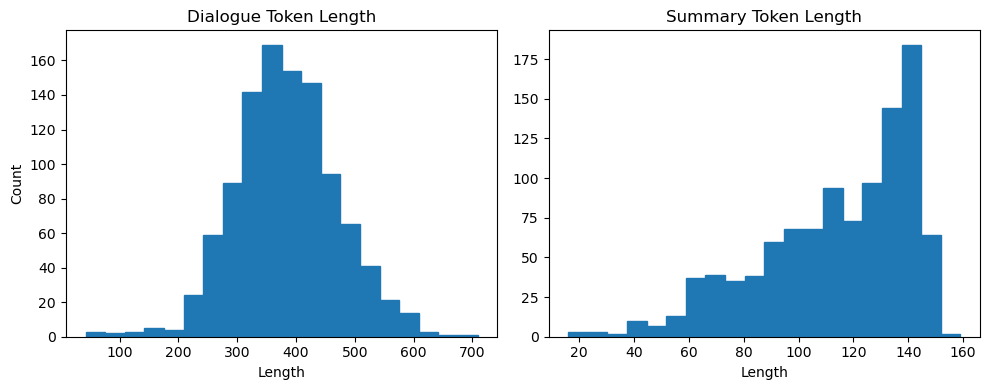

In [18]:
dialogue_token_len = []
for s in train['x']:
  dialogue_token_len.append(len(tokenizer.encode(s)))

summary_token_len = []
for s in train['y']:
  summary_token_len.append(len(tokenizer.encode(s)))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

#### Converting dataframe to datasets

In [17]:
from datasets import Dataset
trainds=Dataset.from_pandas(train)
testds=Dataset.from_pandas(test)

In [22]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['x'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['y'], max_length = 256, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
train_pt = trainds.map(convert_examples_to_features, batched = True)
test_pt=testds.map(convert_examples_to_features, batched = True)

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:3587: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


  0%|          | 0/1 [00:00<?, ?ba/s]

# FineTunnig 

In [35]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

### Epochs=70 

In [22]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus', num_train_epochs=20, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

In [23]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=train_pt, 
                  eval_dataset=test_pt)

In [24]:
# free_gpu_cache()  

In [25]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,1.117500,1.275200


TrainOutput(global_step=640, training_loss=1.6309905439615249, metrics={'train_runtime': 8988.0416, 'train_samples_per_second': 2.316, 'train_steps_per_second': 0.071, 'total_flos': 2.488888707150643e+16, 'train_loss': 1.6309905439615249, 'epoch': 19.65})

In [26]:
trainer.save_model("/kaggle/working/")

In [27]:
model_pegasus.save_pretrained("pegasus-finetuned")

In [28]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [30]:
torch.cuda.empty_cache()

In [32]:
i=0
while(True):
    i=i+1

KeyboardInterrupt: 

In [35]:
free_gpu_cache()  
# rouge_metric = load_metric('rouge')
# score = calculate_metric_on_test_ds(test,rouge_metric,model_pegasus,tokenizer,column_text="x",column_summary='y',batch_size=4)


Initial GPU Usage
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% | 68% |
|  1 |  0% |  6% |
GPU Usage after emptying the cache
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
| ID | GPU | MEM |
------------------
|  0 |  0% | 68% |
|  1 |  0% |  6% |


In [ ]:
# rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
# rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

# pd.DataFrame(rouge_dict, index = ['pegasus'])

In [ ]:
# model = AutoModelForSeq2SeqLM.from_pretrained(model_c).to(device)

In [31]:
model_ckpt = "/kaggle/input/finetuned"


In [38]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [39]:
pred=[]
for i in tqdm(test['x'],total=len(test)):
    batch = tokenizer(i, truncation=True, padding="longest", return_tensors="pt").to(device)
    translated = model_pegasus.generate(**batch)
    tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
    pred.append(tgt_text)

100%|██████████| 116/116 [05:52<00:00,  3.04s/it]


In [40]:
from datasets import load_dataset, load_metric
rouge_metric = load_metric('rouge')
rouge_metric.add_batch(predictions=pred, references=ref_text)
        
#  Finally compute and return the ROUGE scores.
score = rouge_metric.compute()
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.478081,0.272451,0.354642,0.355689


In [ ]:
rouge_metric = load_metric('rouge')
score = calculate_metric_on_test_ds(test,rouge_metric,model_pegasus,tokenizer,4,column_text="x",column_summary='y')

In [24]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015554,0.000102,0.015355,0.015362
